In [1]:
import numpy as np
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from tensorflow.keras import layers, losses, models, optimizers
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
from matplotlib import rcParams as rc
rc['font.size']=12
import random
# from posydon.grids.psygrid import PSyGrid
# from posydon.interpolation.IF_interpolation import BaseIFInterpolator
# import warnings
# warnings.filterwarnings("ignore", category=DeprecationWarning)
from tensorflow import keras

In [2]:
# model = BaseIFInterpolator(filename = "grid_0.0142.pkl")

[  6.749754  35.880997 274.76477 ]


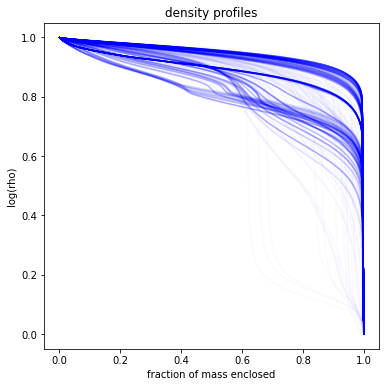

In [3]:
# dataset format:  m1, m2, p, final mass, normalized mass_enc profile,
#  central log(temperature), scaled temperature profile
data1 = np.load("normalized_logrho_profiles.npy",allow_pickle=True)
valid = np.load("normalized_logrho_validation_profiles.npy", allow_pickle=True)
data = random.sample(list(data1), 5000)

m1 = np.array([prof.get('m1') for prof in data], dtype='f') # initial stellar mass
m2 = np.array([prof.get('m2') for prof in data], dtype='f')
p = np.array([prof.get('p') for prof in data], dtype='f') # initial orbital period
linear_x = np.array(np.transpose([m1,m2,p]),dtype='f')

# unst_data=[]
# for i in range(len(linear_x)):
#     if model.test_classifier("interpolation_class", np.array([linear_x[i]])) == 'unstable_MT':
#         unst_data.append(data[i])
        

x = np.log10(linear_x) # 3d inputs for NN

linear_final_mass = np.array([prof.get('final_mass') for prof in data],dtype="f") # final stellar mass
final_mass = np.log10(linear_final_mass)

rho_min = np.array([prof.get('min_logrho') for prof in data], dtype='f')
rho_max = np.array([prof.get('max_logrho') for prof in data], dtype='f')

mass_points = data[0].get('m_arr') # x-values for normalized profiles

rho_minmax = np.array([[prof.get('min_logrho'), prof.get('max_logrho')] for prof in data], dtype='f')

# scaled density profiles
prof_true = np.array([prof.get('logrho_arr') for prof in data],dtype='f')

print(linear_x[0])

# plotting the density data (first 1000)
plt.figure(figsize=(6,6))
for i in range(1000):
    plt.plot(mass_points,prof_true[i],alpha=0.02,c='b')
plt.xlabel("fraction of mass enclosed")
plt.ylabel("log(rho)")
plt.title("density profiles")
plt.show()

In [4]:
# print(len(unst_data))
print(len(x))
# print(len())

5000


In [5]:
i = 0
for rho in rho_min:
    if rho < 0:
#         print(rho)
        i += 1

i

5000

In [6]:
j = 0
for rho in rho_max:
    if rho > 0:
        j += 1
j

5000

In [7]:
data[0]

{'m1': 6.749753988158399,
 'm2': 35.8809950731239,
 'p': 274.7647591766525,
 'final_mass': 5.291036027055654,
 'm_arr': array([0.        , 0.00502513, 0.01005025, 0.01507538, 0.0201005 ,
        0.02512563, 0.03015075, 0.03517588, 0.04020101, 0.04522613,
        0.05025126, 0.05527638, 0.06030151, 0.06532663, 0.07035176,
        0.07537688, 0.08040201, 0.08542714, 0.09045226, 0.09547739,
        0.10050251, 0.10552764, 0.11055276, 0.11557789, 0.12060302,
        0.12562814, 0.13065327, 0.13567839, 0.14070352, 0.14572864,
        0.15075377, 0.15577889, 0.16080402, 0.16582915, 0.17085427,
        0.1758794 , 0.18090452, 0.18592965, 0.19095477, 0.1959799 ,
        0.20100503, 0.20603015, 0.21105528, 0.2160804 , 0.22110553,
        0.22613065, 0.23115578, 0.2361809 , 0.24120603, 0.24623116,
        0.25125628, 0.25628141, 0.26130653, 0.26633166, 0.27135678,
        0.27638191, 0.28140704, 0.28643216, 0.29145729, 0.29648241,
        0.30150754, 0.30653266, 0.31155779, 0.31658291, 0.3216080

In [8]:
valid_m1 = np.array([prof.get('m1') for prof in valid], dtype='f') # initial stellar mass
valid_m2 = np.array([prof.get('m2') for prof in valid], dtype='f')
valid_p = np.array([prof.get('p') for prof in valid], dtype='f') # initial orbital period
valid_linear_x = np.array(np.transpose([valid_m1,valid_m2,valid_p]),dtype='f')

valid_x = np.log10(valid_linear_x) # 3d inputs for NN

valid_linear_final_mass = np.array([prof.get('final_mass') for prof in valid],dtype="f") # final stellar mass
valid_final_mass = np.log10(valid_linear_final_mass)

valid_rho_min = np.array([prof.get('min_logrho') for prof in valid], dtype='f')
valid_rho_max = np.array([prof.get('max_logrho') for prof in valid], dtype='f')

valid_mass_points = valid[0].get('m_arr') # x-values for normalized profiles

valid_rho_minmax = np.array([[prof.get('min_logrho'), prof.get('max_logrho')] for prof in valid], dtype='f')

# scaled density profiles
valid_prof_true = np.array([prof.get('logrho_arr') for prof in valid],dtype='f')

In [9]:
valid.shape
valid_x.shape

(2656, 3)

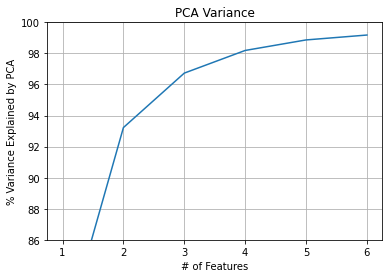

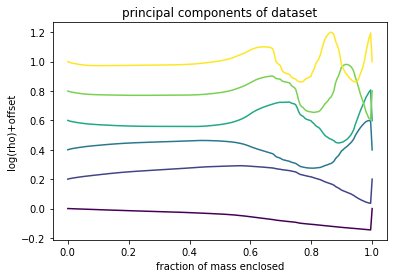

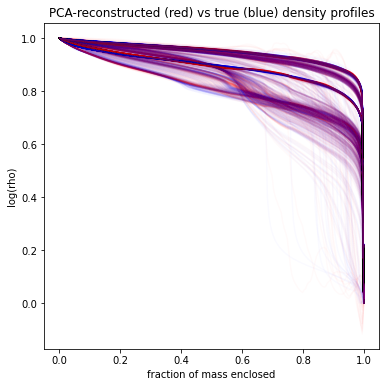

In [10]:
# VALIDATION

valid_pca = PCA(n_components=6).fit(valid_prof_true) # training PCA

valid_prof_low_unscaled = valid_pca.transform(valid_prof_true) # PCA weights 

# scaling factor: st dev of each component
valid_sc = np.std(valid_prof_low_unscaled,axis=0)
valid_prof_low = valid_prof_low_unscaled/valid_sc # scaled pca weights: 6-d NN outputs
valid_reconst = valid_pca.inverse_transform(valid_prof_low*valid_sc) # PCA reconstructed data

plt.figure()
plt.ylabel('% Variance Explained by PCA')
plt.xlabel('# of Features')
plt.title('PCA Variance')
plt.ylim(86,100)
plt.plot(np.arange(1,len(valid_pca.components_)+1),\
         np.cumsum(valid_pca.explained_variance_ratio_)*100)
plt.grid()

plt.show()

colors = plt.cm.viridis(np.linspace(0,1,len(valid_pca.components_)))
plt.figure()
for i in range(len(valid_pca.components_)):
    plt.plot(valid_mass_points,valid_pca.components_[i]+0.2*i,c=colors[i])
plt.xlabel("fraction of mass enclosed")
plt.ylabel("log(rho)+offset")
plt.title("principal components of dataset")
plt.show()

plt.figure(figsize=(6,6))
for i in range(1000):
    plt.plot(valid_mass_points,valid_prof_true[i],alpha=0.02,c='b')
    plt.plot(valid_mass_points,valid_reconst[i],alpha=0.02,c='r')
plt.xlabel("fraction of mass enclosed")
plt.ylabel("log(rho)")
plt.title("PCA-reconstructed (red) vs true (blue) density profiles")
plt.show()

Next, I reshape and reduce dimensionality of the 200-d temperature profile outputs using PCA sphering. I only use the first 6 principal components, which explain ~99% of the variance between the set of original profiles and their PCA reconstructions (as the plot below shows)

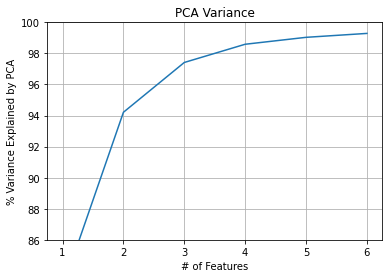

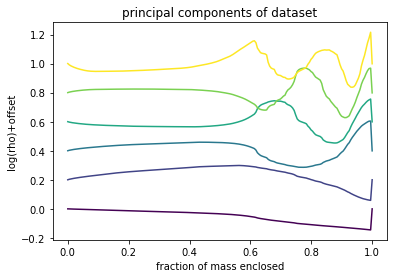

In [11]:
pca = PCA(n_components=6).fit(prof_true) # training PCA

plt.figure()
plt.ylabel('% Variance Explained by PCA')
plt.xlabel('# of Features')
plt.title('PCA Variance')
plt.ylim(86,100)
plt.plot(np.arange(1,len(pca.components_)+1),\
         np.cumsum(pca.explained_variance_ratio_)*100)
plt.grid()

plt.show()

colors = plt.cm.viridis(np.linspace(0,1,len(pca.components_)))
plt.figure()
for i in range(len(pca.components_)):
    plt.plot(mass_points,pca.components_[i]+0.2*i,c=colors[i])
plt.xlabel("fraction of mass enclosed")
plt.ylabel("log(rho)+offset")
plt.title("principal components of dataset")
plt.show()

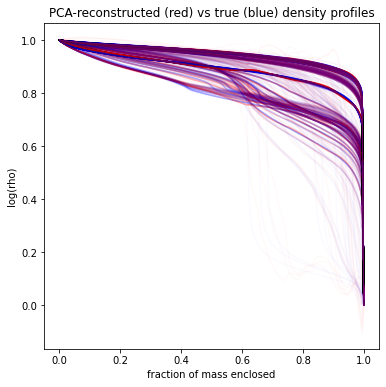

In [12]:
prof_low_unscaled = pca.transform(prof_true) # PCA weights 

# scaling factor: st dev of each component
sc = np.std(prof_low_unscaled,axis=0)
prof_low = prof_low_unscaled/sc # scaled pca weights: 6-d NN outputs
reconst = pca.inverse_transform(prof_low*sc) # PCA reconstructed data

# plotting for the first 1000 points out of 38000 because it gets too cluttered
plt.figure(figsize=(6,6))
for i in range(1000):
    plt.plot(mass_points,prof_true[i],alpha=0.02,c='b')
    plt.plot(mass_points,reconst[i],alpha=0.02,c='r')
plt.xlabel("fraction of mass enclosed")
plt.ylabel("log(rho)")
plt.title("PCA-reconstructed (red) vs true (blue) density profiles")
plt.show()

In [13]:
print(prof_low)
prof_low.shape

[[ 0.95095766  0.07165106  0.40958777 -0.16149226 -0.29856214  0.4962479 ]
 [ 0.7796234  -0.91961926 -0.04521719 -0.2478373   0.3695289  -0.73467237]
 [-0.25484353 -0.5115385  -0.44861555  0.3559892  -0.367016    0.8383945 ]
 ...
 [-0.9123985   0.38707572  0.22620448 -0.08688025  0.02107595 -0.13217267]
 [ 0.9895151  -1.976537   -0.94295293  0.43631315 -0.10289136  0.03631049]
 [ 0.86910045 -0.47924593  0.19401872 -0.3688825   0.19924466 -0.30597693]]


(5000, 6)

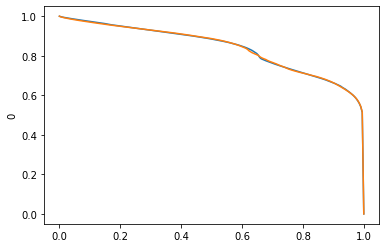

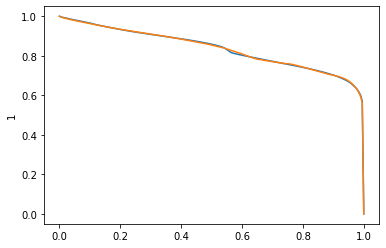

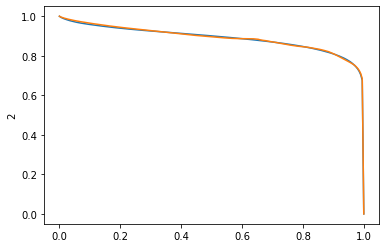

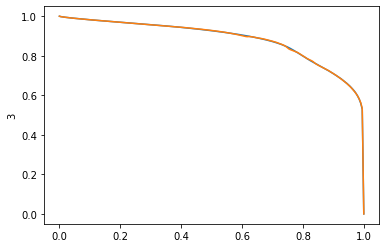

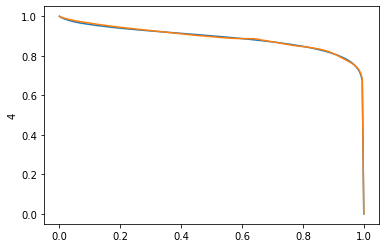

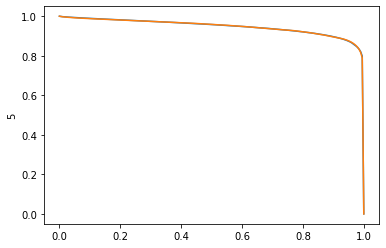

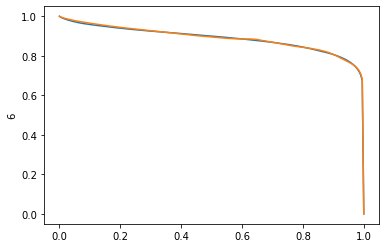

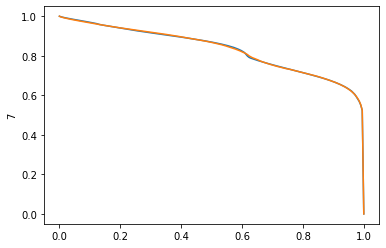

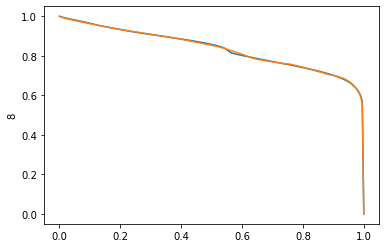

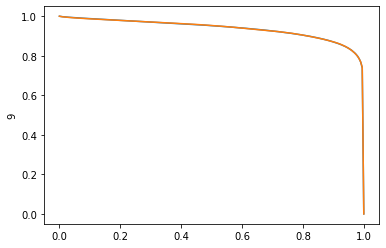

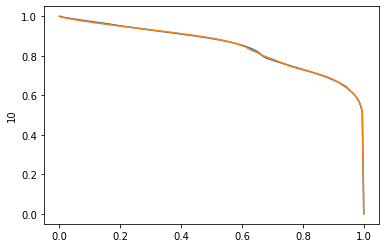

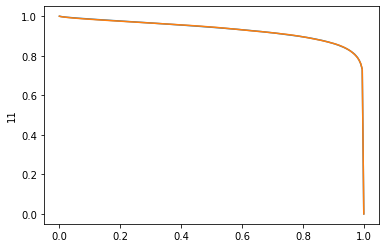

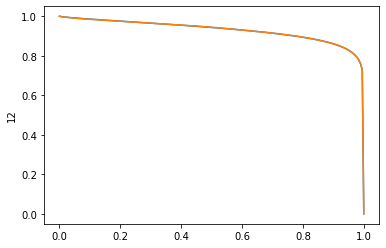

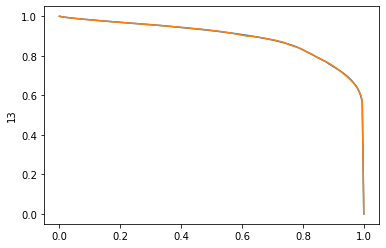

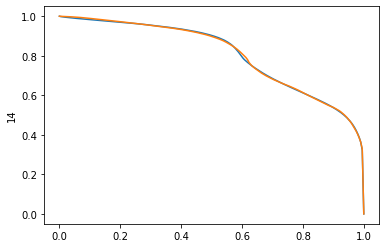

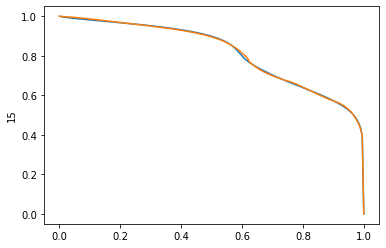

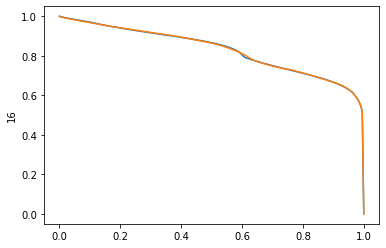

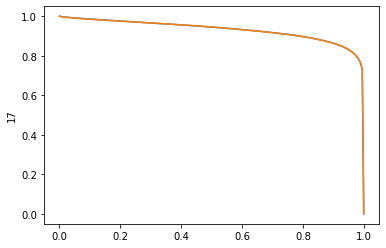

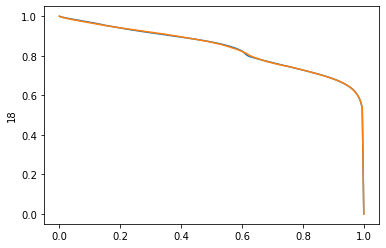

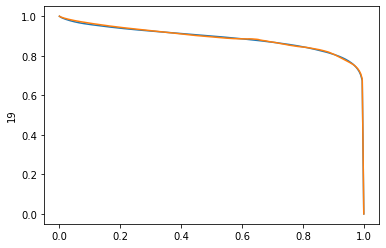

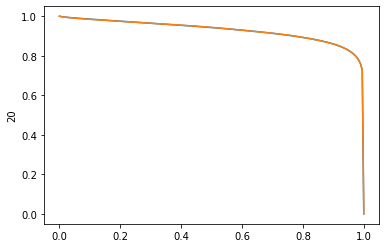

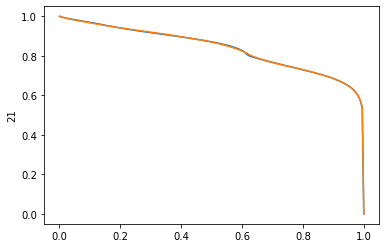

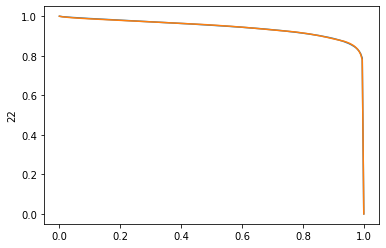

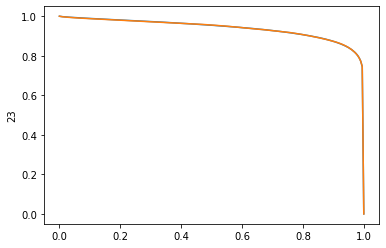

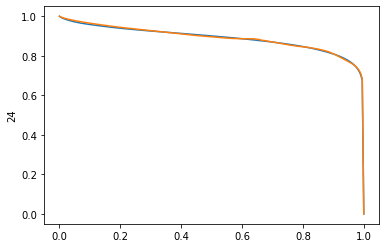

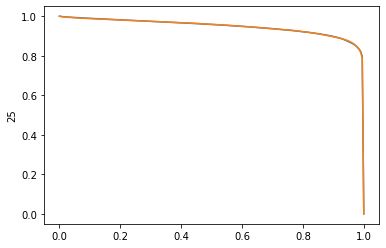

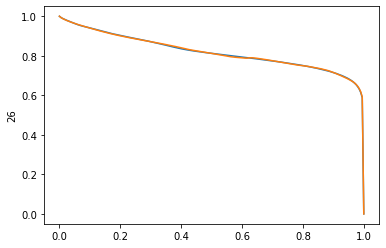

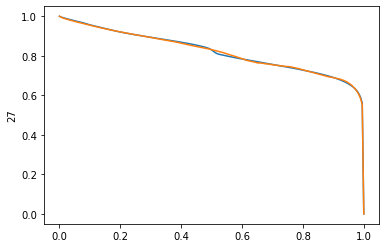

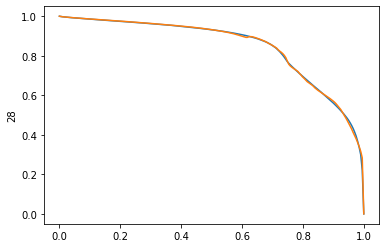

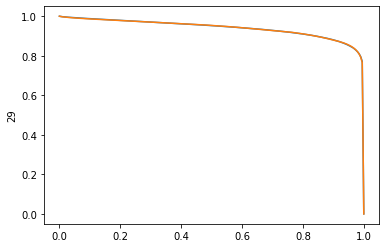

In [14]:
# Comparing true profiles to reconstructed profiles
for i in range(30):
    plt.plot(mass_points,prof_true[i])
    plt.plot(mass_points, reconst[i])
    plt.ylabel(i)
    plt.show()
    
# 12 components gives a nearly identical reconstruction
# 6 components is a bit worse but still good, with slight deviations

My neural network consists of 6 fully-connected layers, with 2 inputs for the initial stellar mass and initial orbital periods, 
and 6 outputs. I use the Adam optimizer on a mean squared error loss function.

In [15]:
print(pca.components_.shape)
print(pca.components_[0])

(6, 200)
[-0.00000000e+00 -5.96800703e-04 -9.69691726e-04 -1.33164495e-03
 -1.67052576e-03 -2.00464623e-03 -2.32749176e-03 -2.65021855e-03
 -2.96996813e-03 -3.29376152e-03 -3.61787737e-03 -3.94102000e-03
 -4.26480360e-03 -4.58703144e-03 -4.91067022e-03 -5.23670204e-03
 -5.58037544e-03 -5.92654338e-03 -6.27138885e-03 -6.64496142e-03
 -7.01032532e-03 -7.36271311e-03 -7.70997675e-03 -8.05398077e-03
 -8.41018744e-03 -8.77488405e-03 -9.12893750e-03 -9.47142858e-03
 -9.81236342e-03 -1.01468237e-02 -1.04713058e-02 -1.07965954e-02
 -1.11274850e-02 -1.14502348e-02 -1.17615014e-02 -1.20693250e-02
 -1.23731811e-02 -1.26735559e-02 -1.29711106e-02 -1.32674864e-02
 -1.35597605e-02 -1.38504980e-02 -1.41417747e-02 -1.44247981e-02
 -1.47079835e-02 -1.49881477e-02 -1.52639002e-02 -1.55386617e-02
 -1.58193633e-02 -1.60918981e-02 -1.63639951e-02 -1.66373383e-02
 -1.69214886e-02 -1.71926674e-02 -1.74674354e-02 -1.77495219e-02
 -1.80274528e-02 -1.83161255e-02 -1.85982008e-02 -1.88836530e-02
 -1.91711541e-02

In [16]:
model = models.Sequential([
    layers.Dense(15,input_dim=3,activation=None),
    layers.Dense(15,input_dim=15,activation="relu"),
    layers.Dense(15,input_dim=15,activation="relu"),
    layers.Dense(15,input_dim=15,activation="tanh"),
    layers.Dense(10,input_dim=10,activation="tanh"),
    layers.Dense(10,input_dim=10,activation="tanh"),
    layers.Dense(6,input_dim=10,activation="linear",name="pre"),
    layers.Dense(200, trainable=False, activation="linear", name="final")
])
# sigmoid activation for output layer?
# 1.19.5
model.get_layer('final').set_weights([pca.components_, np.zeros(200)])
print(model.get_layer('final').get_weights()[0]==pca.components_)
model.summary()
regress = lambda x: model(x)

layer_model = keras.Model(inputs=model.inputs, outputs=model.get_layer('pre').output)

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                60        
                                                                 
 dense_1 (Dense)             (None, 15)                240       
                                                                 
 dense_2 (Dense)             (None, 15)                240       
                                                                 
 dense_3 (Dense)             (None, 15)                240       
                                                                 
 dense_4 (Dense)             (None, 10)                160   

In [17]:
# layer_model = extractor(np.array([[1.,2.,3.]]))

In [18]:
# prof_low_pred = regress(x)
loss_mse = losses.MeanSquaredError()
# loss_mse(prof_low,prof_low_pred).numpy()

In [19]:
print('valid-------------------------')
print(valid_x.shape)
print(valid_prof_low.shape)

print('data--------------------------')
print(x.shape)
print(prof_low.shape)

print(prof_low[0])

valid-------------------------
(2656, 3)
(2656, 6)
data--------------------------
(5000, 3)
(5000, 6)
[ 0.95095766  0.07165106  0.40958777 -0.16149226 -0.29856214  0.4962479 ]


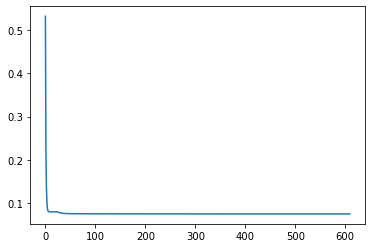

In [20]:
model.compile(optimizers.Adam(clipnorm=1),loss=loss_mse)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=40)
history = model.fit(x,prof_true,epochs=3000,callbacks=[callback],verbose=0, validation_data=(valid_x, valid_prof_true))
plt.plot(history.history['loss'])
plt.show()
# fit to prof_true instead of prof_low

In [21]:
mid = model.layers[6].output


Next, I have two NNs to predict the final mass and central temperature that I normalized out at the beginning:

In [22]:
# model to predict final mass - 3 inputs, 1 output
model_mass = models.Sequential([
    layers.Dense(10,input_dim=3,activation=None),
    layers.Dense(10,input_dim=10,activation='relu'),
    layers.Dense(10,input_dim=10,activation='tanh'),
    layers.Dense(10,input_dim=10,activation='tanh'),
    layers.Dense(10,input_dim=10,activation='tanh'),
    layers.Dense(10,input_dim=10,activation='tanh'),
    layers.Dense(1,activation=None)
])

regress_mass = lambda x: model_mass(x)

mpred = regress_mass(x)

loss_mse = losses.MeanSquaredError()
# loss_mse(final_mass,mpred).numpy()

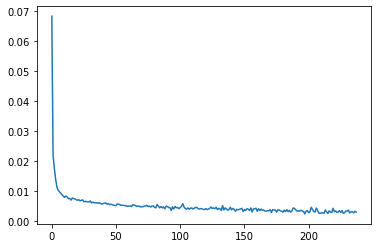

157/157 - 0s - loss: 0.0029 - 142ms/epoch - 904us/step


0.002936712931841612

In [23]:
model_mass.compile(optimizers.Adam(clipnorm=1),loss="mse")
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=40)
history = model_mass.fit(x,final_mass,epochs=2000,\
                         callbacks=[callback],verbose=0)
plt.plot(history.history['loss'])
plt.show()

model_mass.evaluate(x,final_mass,verbose=2)

In [24]:
# 3 inputs and 2 outputs (min/max logrho)
model_rho = models.Sequential([
    layers.Dense(10,input_dim=3,activation='relu'),
    layers.Dense(10,input_dim=10,activation='relu'),
    layers.Dense(10,input_dim=10,activation='tanh'),
    layers.Dense(10,input_dim=10,activation='tanh'),
    layers.Dense(10,input_dim=10,activation='tanh'),
    layers.Dense(10,input_dim=10,activation='tanh'),
    layers.Dense(2,activation=None)
])

regress_rho = lambda x: model_rho(x)

rhopred = regress_rho(x)

loss_mse = losses.MeanSquaredError()
# loss_mse(rho_minmax,rhopred).numpy()

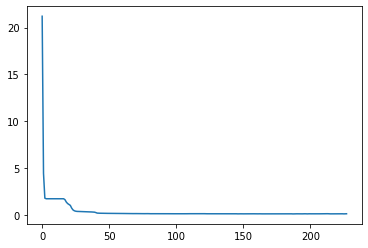

157/157 - 0s - loss: 0.0995 - 141ms/epoch - 897us/step


0.09945669770240784

In [25]:
model_rho.compile(optimizers.Adam(clipnorm=1),loss="mse")
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=40)
history = model_rho.fit(x,rho_minmax,epochs=2000,\
                         callbacks=[callback],verbose=0)
plt.plot(history.history['loss'])
plt.show()

model_rho.evaluate(x,rho_minmax,verbose=2)

My final prediction brings together all 3 NNs to reconstruct the temperature profile prediction for any new binary in this 2d slice of parameter space. 

In [26]:
def pred_profiles(lin_x):
    x = np.log10(lin_x)
    final_log_masses = regress_mass(x)
    final_linear_masses = 10**final_log_masses
    
    min_rho = np.array(regress_rho(x)[:,0])
    max_rho = np.array(regress_rho(x)[:,1])
    min_rho.shape = max_rho.shape = (len(min_rho), 1)
    
    norm_profiles = regress(x)
    
    density_profiles = norm_profiles*(max_rho-min_rho) + min_rho
    xcoords = mass_points*final_linear_masses[:,np.newaxis]

    return xcoords,density_profiles,norm_profiles

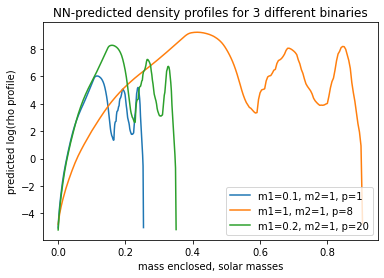

<tf.Tensor: shape=(3, 1, 200), dtype=float32, numpy=
array([[[0.        , 0.0012737 , 0.00254741, 0.00382111, 0.00509481,
         0.00636852, 0.00764222, 0.00891592, 0.01018962, 0.01146333,
         0.01273703, 0.01401073, 0.01528444, 0.01655814, 0.01783184,
         0.01910554, 0.02037925, 0.02165295, 0.02292665, 0.02420036,
         0.02547406, 0.02674776, 0.02802147, 0.02929517, 0.03056887,
         0.03184258, 0.03311628, 0.03438998, 0.03566368, 0.03693739,
         0.03821109, 0.0394848 , 0.0407585 , 0.0420322 , 0.0433059 ,
         0.04457961, 0.04585331, 0.04712701, 0.04840071, 0.04967442,
         0.05094812, 0.05222182, 0.05349553, 0.05476923, 0.05604294,
         0.05731663, 0.05859034, 0.05986404, 0.06113775, 0.06241145,
         0.06368516, 0.06495886, 0.06623255, 0.06750626, 0.06877997,
         0.07005367, 0.07132737, 0.07260107, 0.07387478, 0.07514848,
         0.07642218, 0.07769588, 0.07896959, 0.08024329, 0.081517  ,
         0.0827907 , 0.0840644 , 0.08533811, 0.086

In [27]:
testpts = [[0.1,1,1],[1,1,8],[0.2,1,20]]
testpts1 = [[2, 6, 24], [2, 2, 12], [0.8, 2, 24]]
xcoords,profiles,bajk = pred_profiles(testpts)
plt.figure()
for i in range(len(xcoords)):
    plt.plot(xcoords[i][0],profiles[i],label =\
             "m1="+str(testpts[i][0])+", m2="+str(testpts[i][1])+", p="+str(testpts[i][2]))
    plt.xlabel("mass enclosed, solar masses")
    plt.ylabel("predicted log(rho profile)")
plt.title("NN-predicted density profiles for 3 different binaries")
plt.legend()
plt.show()
len(xcoords)
xcoords

In [28]:
print(valid_linear_x[1])
print(valid[1])
print(valid_prof_true[1])

[3.6099567 1.4722869 1.9690907]
{'m1': 3.6099567262360686, 'm2': 1.4722869662656768, 'p': 1.969090642707754, 'final_mass': 3.147695403118807, 'm_arr': array([0.        , 0.00502513, 0.01005025, 0.01507538, 0.0201005 ,
       0.02512563, 0.03015075, 0.03517588, 0.04020101, 0.04522613,
       0.05025126, 0.05527638, 0.06030151, 0.06532663, 0.07035176,
       0.07537688, 0.08040201, 0.08542714, 0.09045226, 0.09547739,
       0.10050251, 0.10552764, 0.11055276, 0.11557789, 0.12060302,
       0.12562814, 0.13065327, 0.13567839, 0.14070352, 0.14572864,
       0.15075377, 0.15577889, 0.16080402, 0.16582915, 0.17085427,
       0.1758794 , 0.18090452, 0.18592965, 0.19095477, 0.1959799 ,
       0.20100503, 0.20603015, 0.21105528, 0.2160804 , 0.22110553,
       0.22613065, 0.23115578, 0.2361809 , 0.24120603, 0.24623116,
       0.25125628, 0.25628141, 0.26130653, 0.26633166, 0.27135678,
       0.27638191, 0.28140704, 0.28643216, 0.29145729, 0.29648241,
       0.30150754, 0.30653266, 0.31155779, 0.

In [29]:
xcoords[1][0]

<tf.Tensor: shape=(200,), dtype=float32, numpy=
array([0.        , 0.00454378, 0.00908755, 0.01363133, 0.0181751 ,
       0.02271888, 0.02726265, 0.03180643, 0.03635021, 0.04089398,
       0.04543776, 0.04998153, 0.05452531, 0.05906908, 0.06361286,
       0.06815663, 0.07270041, 0.07724418, 0.08178796, 0.08633174,
       0.09087551, 0.09541929, 0.09996306, 0.10450684, 0.10905062,
       0.11359439, 0.11813816, 0.12268195, 0.12722571, 0.1317695 ,
       0.13631326, 0.14085704, 0.14540082, 0.1499446 , 0.15448837,
       0.15903215, 0.16357592, 0.16811968, 0.17266348, 0.17720725,
       0.18175103, 0.1862948 , 0.19083858, 0.19538234, 0.19992612,
       0.2044699 , 0.20901369, 0.21355745, 0.21810123, 0.222645  ,
       0.22718878, 0.23173255, 0.23627633, 0.24082012, 0.24536389,
       0.24990766, 0.25445142, 0.2589952 , 0.263539  , 0.26808277,
       0.27262652, 0.2771703 , 0.28171408, 0.28625786, 0.29080164,
       0.2953454 , 0.2998892 , 0.30443296, 0.30897674, 0.31352052,
       0.31806

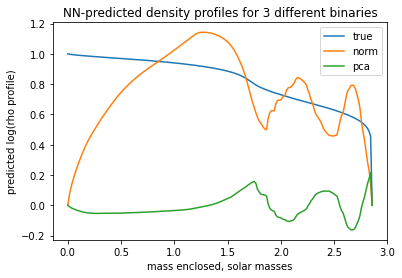

tf.Tensor(
[[-8.641076   -7.6816664  -7.0208282  -6.444866   -5.939912   -5.4679193
  -5.03757    -4.630206   -4.2420506  -3.8700762  -3.5144706  -3.176355
  -2.8601713  -2.5642066  -2.288434   -2.0281076  -1.7732038  -1.5282283
  -1.2914901  -1.0427432  -0.8000088  -0.5820799  -0.36357975 -0.15216541
   0.0595808   0.26817608  0.47011185  0.67785454  0.87913895  1.078413
   1.2726688   1.4602442   1.6498337   1.8286114   1.9997759   2.1653461
   2.3257608   2.4818153   2.6321516   2.7798424   2.921319    3.0596533
   3.1956367   3.3255148   3.4517078   3.5753965   3.696395    3.812786
   3.9260159   4.039113    4.1494827   4.2583036   4.3582087   4.4644747
   4.568948    4.665163    4.7649813   4.8583145   4.9571886   5.054427
   5.156439    5.258856    5.362235    5.4661455   5.5712013   5.675148
   5.781493    5.8878155   5.99492     6.1032867   6.2104874   6.3206377
   6.432023    6.5427647   6.653595    6.764785    6.8769903   6.9879417
   7.096656    7.206437    7.315792    7.421

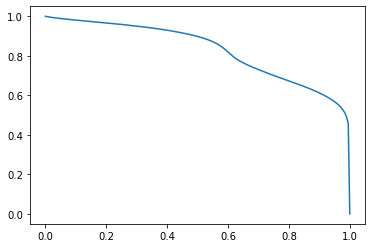

In [33]:
testpts = [[3.6099567, 1.4722869, 1.9690907]]
xcoords,profiles,norm = pred_profiles(testpts)
# profiles = np.log10(profiles)
combo=0
for comp in pca.components_:
    combo += comp
plt.figure()
# plt.plot(xcoords[0][0],profiles[0],label = "pred")
plt.plot(xcoords[0][0],valid_prof_true[1], label="true")
plt.plot(xcoords[0][0],norm[0],label="norm")
plt.plot(xcoords[0][0],comp,label="pca")
plt.xlabel("mass enclosed, solar masses")
plt.ylabel("predicted log(rho profile)")
plt.title("NN-predicted density profiles for 3 different binaries")
plt.legend()
plt.show()
valid_linear_x[1]
print(profiles)

plt.figure()
plt.plot(valid_mass_points,valid_prof_true[1])
plt.show()

In [ ]:
testpts = [[61.0721973, 11.0880684, 104.6672966]]
xcoords1,profiles1 = pred_profiles(testpts)
# profiles1 = np.log10(profiles1)
plt.figure()
plt.plot(xcoords1[0][0],profiles1[0],label = "pred")
plt.plot(mass_points, valid_prof_true[2], label="true")
plt.xlabel("mass enclosed, solar masses")
plt.ylabel("predicted log(rho profile)")
plt.title("NN-predicted density profiles for 3 different binaries")
plt.legend()
plt.show()
valid_linear_x[2]

plt.figure()
plt.plot(valid_mass_points,valid_prof_true[2])
plt.show()

In [ ]:
testpts = [[0.81399655, 4.9406686, 0.571922]]
xcoords2,profiles2 = pred_profiles(testpts)
# profiles2 = np.log10(profiles2)
plt.figure()
plt.plot(xcoords2[0][0],profiles2[0],label = "pred")
plt.plot(mass_points, valid_prof_true[3], label="true")
plt.xlabel("mass enclosed, solar masses")
plt.ylabel("predicted log(rho profile)")
plt.title("NN-predicted density profiles for 3 different binaries")
plt.legend()
plt.show()
valid_linear_x[3]

plt.figure()
plt.plot(valid_mass_points,valid_prof_true[3])
plt.show()

In [ ]:
testpts = [[55.17751, 3.7443938, 51.425518]]
xcoords3,profiles3 = pred_profiles(testpts)
# profiles3 = np.log10(profiles3)
plt.figure()
plt.plot(xcoords3[0][0],profiles3[0],label = "pred")
plt.plot(mass_points, valid_prof_true[1000], label="true")
plt.xlabel("mass enclosed, solar masses")
plt.ylabel("predicted log(rho profile)")
plt.title("NN-predicted density profiles for 3 different binaries")
plt.legend()
plt.show()
valid_linear_x[1000]
plt.figure()
plt.plot(valid_mass_points,valid_prof_true[1000])
plt.show()

In [ ]:
testpts = [[32.53242, 5.285393, 1.3682235]]
xcoords4,profiles4 = pred_profiles(testpts)
# profiles4 = np.log10(profiles4)
plt.figure()
plt.plot(xcoords4[0][0],profiles4[0],label = "pred")
plt.plot(mass_points, valid_prof_true[2000], label="true")
plt.xlabel("mass enclosed, solar masses")
plt.ylabel("predicted log(rho profile)")
plt.title("NN-predicted density profiles for 3 different binaries")
plt.legend()
plt.show()
valid_linear_x[2000]

plt.figure()
plt.plot(valid_mass_points,valid_prof_true[2000])
plt.show()

In [ ]:
valid_linear_x[2000]

In [ ]:
valid_mass_points

In [ ]:
tout = regress(np.array([x[0]]))

In [ ]:
print(len(tout[0]))
print(tout)

In [ ]:
np.absolute(pca.components_[0])